<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
!pip install fitter
from fitter import Fitter
from tensorflow import keras
import tensorflow_probability as tfp



In [25]:
import tensorflow as tf

In [24]:
from tensorflow.keras import layers


# 1. Load and insepct the dataset

In [2]:
df = pd.read_csv('data/AMS_descritt_noSM_meltD_adim.csv', sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


## 1.1. Preprocess the dataset
spiegazione di come vengono taggruppate i vari dati

In [3]:
df.columns

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')

In [4]:
new_df = df.copy()
new_df.drop("AMS",axis=1, inplace=True)

In [5]:
durations = [1, 3, 6, 12, 24]

grouped_AMS = df.groupby(['ID', 'duration[h]'])['AMS'].apply(list).reset_index()
grouped_IdD = df.groupby(['ID', 'duration[h]'])['mean_IdD'].unique().apply(lambda x:  x[0] if len(x) > 0 else None).reset_index()

pivoted_AMS = grouped_AMS.pivot(index='ID', columns='duration[h]', values='AMS')
pivoted_IdD = grouped_IdD.pivot(index='ID', columns='duration[h]', values='mean_IdD')

pivoted_AMS.columns = [f'AMS_{col}' for col in pivoted_AMS.columns]
pivoted_IdD.columns = [f'IdD_{col}' for col in pivoted_IdD.columns]

pivoted_AMS.reset_index(inplace=True)
pivoted_IdD.reset_index(inplace=True)

print(pivoted_AMS)
new_df = pd.merge(new_df, pivoted_AMS, on='ID')
new_df = pd.merge(new_df, pivoted_IdD, on='ID')

new_df.head()

         ID                                              AMS_1  \
0      5001           [1.2212389380530972, 0.7787610619469026]   
1      5002  [1.2190179267342167, 0.9799948038451548, 1.153...   
2      5003  [1.010657846380007, 0.7883131201764058, 1.2936...   
3      5004  [1.3696369636963697, 1.3283828382838283, 0.924...   
4      5005  [1.600310941245061, 2.139275766016713, 0.82088...   
...     ...                                                ...   
2347  21330  [0.8005865102639296, 0.8278173439463762, 0.762...   
2348  21334  [1.0159744408945688, 0.4536741214057508, 1.175...   
2349  21336  [1.1396526772793054, 1.719247467438495, 0.9638...   
2350  21337  [0.9292502639915522, 1.620380147835269, 0.9699...   
2351  21338  [1.1151439299123902, 1.1908635794743427, 0.936...   

                                                  AMS_3  \
0     [1.1067961165048543, 0.8932038834951457, 1.184...   
1     [0.8760114425827543, 1.0752758479771147, 1.387...   
2     [1.0150596252129471, 0.9

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,AMS_1,AMS_3,AMS_6,AMS_12,AMS_24,IdD_1,IdD_3,IdD_6,IdD_12,IdD_24
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
2,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
3,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
4,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875


In [6]:
# Take only the rows with unique ID
df_unique = new_df.drop_duplicates(subset=['ID'], keep='first')
df_unique = df_unique.drop(['duration[h]', 'mean_IdD'], axis=1)
df_unique.reset_index(drop=True, inplace=True)

In [7]:
df2 = pd.read_csv('data/gumMap_statbench_Gumfit_NEW.csv', sep=',', encoding='utf-8')
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [8]:
# Take the first 100 ID from df2 and use them to create the test set from df_unique
test_ID = df2['ID'].to_list()[:100]
test_df = df_unique[df_unique['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

In [9]:
# Drop the test set from df_unique and create the train set and validation set
df_unique = df_unique.drop(df_unique[df_unique['ID'].isin(test_ID)].index,)

validation_split = 0.1
train_df, val_df = train_test_split(df_unique, test_size=validation_split, random_state=42)

In [10]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [11]:
print('Train Set:', len(train_df))
print('Validation Set:', len(val_df))
print('Test Set:', len(test_df))

Train Set: 2026
Validation Set: 226
Test Set: 100


In [30]:
train_df.columns

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'loc', 'scale', '99perc',
       '95perc', '80perc', 'AMS_1', 'AMS_3', 'AMS_6', 'AMS_12', 'AMS_24',
       'IdD_1', 'IdD_3', 'IdD_6', 'IdD_12', 'IdD_24'],
      dtype='object')

## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

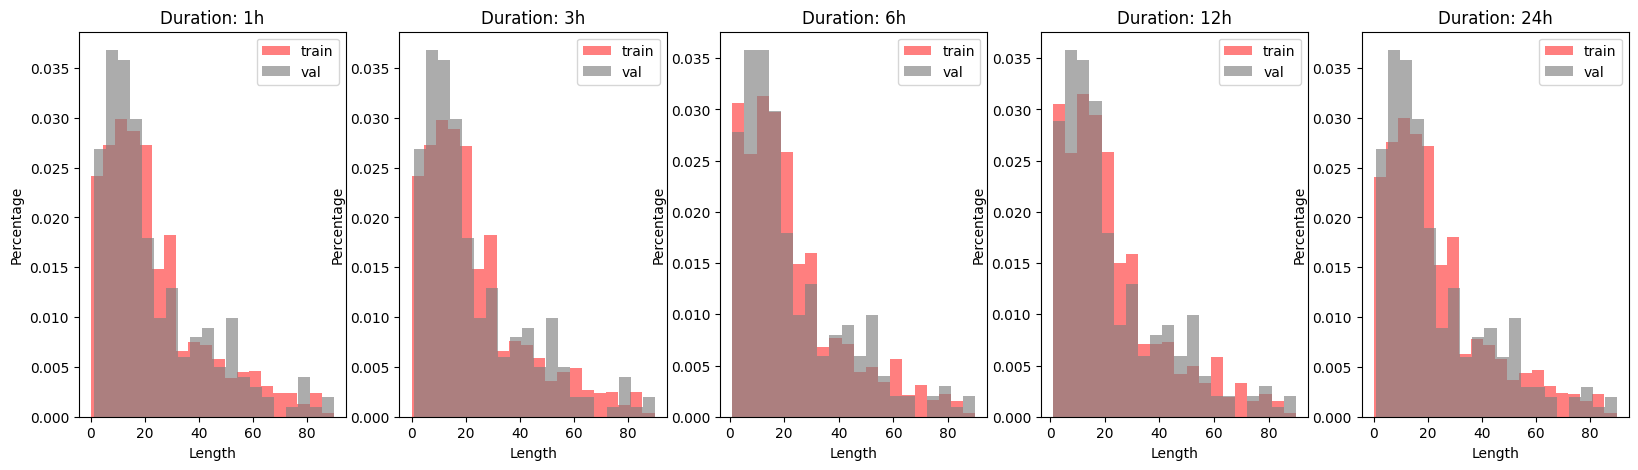

In [13]:

def compute_timeseries_length(df, duration):
    lenghts = []
    for i in range(len(df)):
        series = df['AMS_'+str(duration)][i]
        if np.isnan(series).any():
            lenghts.append(0)
        else:
            lenghts.append(len(series))
    return lenghts

def plot_timeseries_length(df_train, df_val, durations):
    fig, axs = plt.subplots(1, len(durations), figsize=(20, 5))
    for i, duration in enumerate(durations):
        lenghts_train = compute_timeseries_length(df_train, duration)
        lenghts_val = compute_timeseries_length(df_val, duration)
        axs[i].set_ylabel('Percentage')
        axs[i].set_title('Duration: '+str(duration)+'h')
        axs[i].set_xlabel('Length')
        axs[i].hist(lenghts_train, bins=20, alpha=0.5, label='train', density=True, color='red')
        axs[i].hist(lenghts_val, bins=20, alpha=0.65, label='val', density=True, color='gray')
        axs[i].legend()
    plt.show()

plot_timeseries_length(train_df, val_df, durations)

### MAP distribution for training and validation

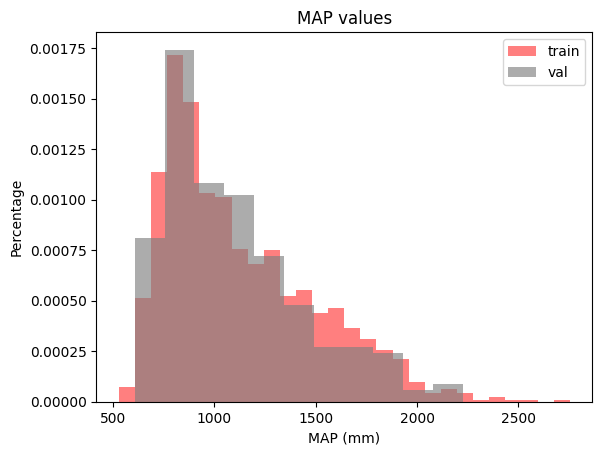

In [14]:
plt.hist(train_df['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_df['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

In [15]:
#NOTA: potremmo standardizzare all'inizio prima di creare le liste almeno è più lineare


def standardize_AMS(df, durations):

    for duration in durations:

        df['AMS_'+str(duration)] = df.apply(lambda row: [x * row['IdD_'+str(duration)] for x in row['AMS_'+str(duration)]] if isinstance(row['AMS_'+str(duration)], list) else row['AMS_'+str(duration)], axis=1)

        # Calcola il valore minimo e massimo per la colonna 'AMS_duration'
        min_col = df['AMS_'+str(duration)].apply(lambda x: min(x) if isinstance(x, list) else x).min()
        max_col = df['AMS_'+str(duration)].apply(lambda x: max(x) if isinstance(x, list) else x).max()

        # Standardizza ogni elemento della lista tra 0 e 1
        df['AMS_'+str(duration)] = df.apply(lambda row: [(x - min_col) / (max_col - min_col) for x in row['AMS_'+str(duration)]] if isinstance(row['AMS_'+str(duration)], list) else row['AMS_'+str(duration)], axis=1)

    return df

train_df = standardize_AMS(train_df, durations)
val_df = standardize_AMS(val_df, durations)
test_df = standardize_AMS(test_df, durations)


(array([2.89692702, 6.89744528, 7.4492409 , 5.65590513, 3.17282483,
        3.03487592, 2.20718249, 1.65538687, 0.41384672, 0.41384672,
        0.27589781, 0.27589781, 0.13794891, 0.        , 0.27589781]),
 array([0.05801105, 0.08677716, 0.11554328, 0.14430939, 0.17307551,
        0.20184162, 0.23060773, 0.25937385, 0.28813996, 0.31690608,
        0.34567219, 0.37443831, 0.40320442, 0.43197053, 0.46073665,
        0.48950276]),
 <BarContainer object of 15 artists>)

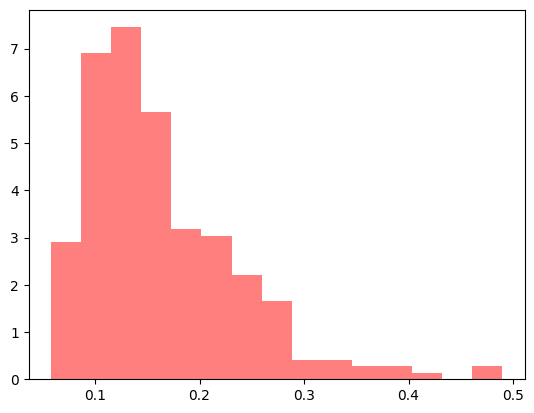

In [16]:
ams_1 = train_df['AMS_1'].tolist()

#remove nan values from the list
ams_1 = [x for x in ams_1 if str(x) != 'nan']
ams_1 = [item for sublist in ams_1[:8] for item in sublist]


#plot the histogram
plt.hist(ams_1, bins='auto', alpha=0.5, label='train', density=True, color='red')

2024-01-11 16:40:45.530 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=135.942876)
2024-01-11 16:40:45.566 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=266.128682)
2024-01-11 16:40:45.581 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=731.560123)
2024-01-11 16:40:45.583 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED gumbel distribution (taking more than 30 seconds)
2024-01-11 16:40:45.702 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=156.469044)
2024-01-11 16:40:45.940 | WARNING  | fitter.fitter:plot_pdf:417 - gumbel was not fitted. no parameters available


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,135.942876,29.766684,40.354971,inf,0.034140,9.208004e-01
beta,156.469044,121.129752,135.247469,inf,0.066076,2.116630e-01
norm,266.128682,191.023919,198.082777,inf,0.119572,1.347566e-03
uniform,731.560123,-164.101395,-157.042537,inf,0.452015,1.565419e-47
gumbel,inf,inf,inf,inf,NaN,NaN


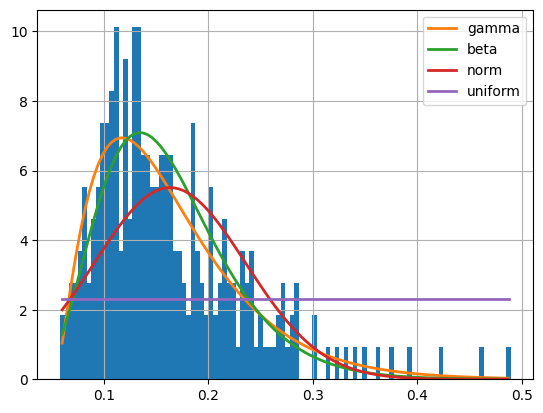

In [17]:
ams_1_np = np.array(ams_1)
f = Fitter(ams_1_np, distributions=['beta', 'gamma', 'norm', 'uniform','gumbel'])
f.fit()
f.summary()


In [27]:
mean = np.mean(ams_1)
var = np.var(ams_1)
#momentum rule
a = ((1 - mean)/ var - 1 / mean)* mean**2
b = a * (1 / mean - 1 )
print(a,b)

4.093313746878154 20.96631078638266


In [28]:
def build_nn_beta_model(input_shape, hidden, a=1, b=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Beta(a,b)
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model

In [29]:
build_nn_beta_model(input_shape=len(ams_1,), hidden=[], a=a, b=b)

In [53]:
train_df.head(5)
for x in [1,3,6,12,24]:
  train_df["AMS_" + str(x)] = [np.nanmean(sublist) for sublist in train_df["AMS_"+str(x)]]


In [55]:
train_df.head(5)

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,AMS_1,AMS_3,AMS_6,AMS_12,AMS_24,IdD_1,IdD_3,IdD_6,IdD_12,IdD_24
0,9380,'Melegnano',90.964295,3.898290,0.858622,0.606050,152.281257,104.700774,233.903377,46.875647,...,0.174033,0.174033,0.174033,0.174033,0.174033,31.500000,38.638095,48.742857,59.577273,72.904545
1,12163,'Fossano_2',360.764973,9.797826,1.848248,2.946933,189.374908,118.169549,359.137335,341.587794,...,0.135742,0.135742,0.135742,0.135742,0.135742,24.569231,29.484615,36.923077,46.400000,59.692308
2,9014,'Barni',767.637133,124.744350,22.700332,12.193675,189.562921,99.345678,246.645541,497.279626,...,0.315391,0.315391,0.315391,0.315391,0.315391,57.085714,79.028571,89.342857,100.114286,118.857143
3,21018,'Brendola',157.061393,90.859242,11.222639,8.708569,187.641838,59.111240,68.528559,36.508654,...,0.193054,0.193054,0.193054,0.193054,0.193054,34.942857,42.300000,51.878571,66.928571,81.814286
4,8072,'Colle_Del_Melogno',1017.392522,148.313182,20.703809,7.836887,164.489004,67.864609,325.281240,363.897139,...,0.184925,0.184925,0.184925,0.184925,0.184925,33.471429,61.000000,86.950000,117.137500,151.655357
